In [1]:
#pandas version

import pandas as pd
pd.__version__

'2.2.3'

In [98]:
#libraries
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [55]:
#task 1
urls = [
    "https://en.wikipedia.org/wiki/List_of_earthquakes_2001%E2%80%932010",
    "https://en.wikipedia.org/wiki/List_of_earthquakes_2011%E2%80%932020",
    "https://en.wikipedia.org/wiki/List_of_earthquakes_2021%E2%80%932030"]

all_tables = []

for url in urls:
    tables = pd.read_html(url, header=0) #reading the tables
    for tbl in tables:
        if tbl.shape[1] >= 8: #keeping tables with 8+ columns
            all_tables.append(tbl)

eq_df = pd.concat(all_tables, ignore_index=True)

eq_df.head(5)

,Date,Time (UTC),Place,Lat.,Long.,Fatalities,Magnitude,Comments,Sources,Source
0,"January 1, 2001",06:57,"Mindanao, Philippines",6.898,126.579,0,7.5,Mw (HRV).,NaN,NaN
1,"January 9, 2001",16:49,Vanuatu,-14.928,167.170,0,7.1,Mw (USGS).,NaN,NaN
2,"January 10, 2001",16:02,"Kodiak Island region, Alaska, United States",57.078,-153.211,0,6.9,Mw (HRV).,NaN,NaN
3,"January 13, 2001",17:33,Offshore El Salvador see January 2001 El Salv...,13.049,-88.660,1145,7.7,Mw (HRV).,NaN,NaN
4,"January 26, 2001",03:16,"Gujarat, India see 2001 Gujarat earthquake",23.419,70.232,20023,7.7,Mw (HRV).,NaN,NaN


In [57]:
#task 2: data cleaning


#part 1: making combined datetime column
eq_df['datetime'] = pd.to_datetime(
    eq_df['Date'].astype(str) + ' ' + eq_df['Time (UTC)'].astype(str),
    errors='coerce'
)


#part 2: fatalities
def fatalities(x):
    if pd.isna(x):
        return pd.NA

    s = str(x).lower()

    # finding the lower range
    m = re.search(r'(\d[\d,]*)\s*[~–-]\s*\d[\d,]*', s)
    if m:
        return int(m.group(1).replace(',', ''))

    # “dead” or “killed”
    m = re.search(r'(\d[\d,]*)\s*(dead|killed)', s)
    if m:
        return int(m.group(1).replace(',', ''))

    # only missing
    if 'missing' in s and 'dead' not in s and 'killed' not in s:
        m = re.search(r'(\d[\d,]*)', s)
        if m:
            return int(m.group(1).replace(',', ''))

    # first number
    m = re.search(r'(\d[\d,]*)', s)
    if m:
        return int(m.group(1).replace(',', ''))

    # nan
    return pd.NA

eq_df['Fatalities'] = eq_df['Fatalities'].apply(fatalities)

# eq_df[['Fatalities']].head(10)
# eq_df['Fatalities'].dtype


#part 3: magnitude

def magnitude(x):
    if pd.isna(x):
        return np.nan

    s = str(x).strip()

    # upper range
    m = re.match(r'.*?([0-9]*\.?[0-9]+)\s*[~–-]\s*([0-9]*\.?[0-9]+).*', s)
    if m:
        return float(m.group(2))

    # finding the first number
    m = re.search(r'([0-9]*\.?[0-9]+)', s)
    if m:
        return float(m.group(1))

    # nan
    return np.nan

eq_df['Magnitude'] = eq_df['Magnitude'].apply(magnitude)

# eq_df['Magnitude'].head(10)
# eq_df['Magnitude'].dtype


#part 4: magniture bins
bins   = [float('-inf'), 5.0, 7.0, float('inf')] #defining bins
labels = ['Low', 'Moderate', 'High'] #naming the bins
#creating the bins/column
eq_df['magnitude_cat'] = pd.cut(
    eq_df['Magnitude'],
    bins=bins,
    labels=labels,
    right=False
)


#part 5: removing quakes after 4/17/25
eq_df = eq_df[eq_df['datetime'] < '2025-04-17']


In [64]:

#part 6: column selection

#renaming columns to match the readme file
eq_df = eq_df.rename(columns={
    'datetime':    'date_time',
    'Lat.':         'latitude',
    'Long.':        'longitude',
    'Fatalities':  'fatalities',
    'Magnitude':  'magnitude'})

#dropping columns
eq_df = eq_df[
    [
        'date_time',
        'latitude',
        'longitude',
        'fatalities',
        'magnitude',
        'magnitude_cat'
    ]
]

#part 7: printing the data
eq_df.head(5)

#part 8: printing the info
eq_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date_time      881 non-null    datetime64[ns]
 1   latitude       881 non-null    float64       
 2   longitude      881 non-null    float64       
 3   fatalities     881 non-null    int64         
 4   magnitude      881 non-null    float64       
 5   magnitude_cat  881 non-null    category      
dtypes: category(1), datetime64[ns](1), float64(3), int64(1)
memory usage: 35.5 KB


In [65]:
#TASK 3: saving the data
eq_df.to_csv("earthquakes.csv", index=False)

/var/folders/c8/q7j5g0wj73s806hqbvp128c40000gq/T/ipykernel_39173/3454707259.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_fat = df_2.groupby('magnitude_cat')['fatalities'].mean()


magnitude_cat
Low            2.670886
Moderate     140.995516
High        1549.542373
Name: fatalities, dtype: float64


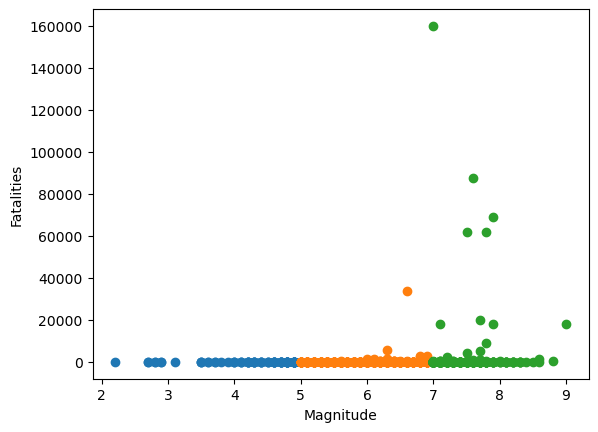

In [ ]:
#TASK 4: questions

#1)
eq_df.shape

#2)
eq_df['magnitude'].mean()
eq_df['magnitude'].median()

#3)
fatal_by_date = eq_df.groupby(eq_df['date_time'].dt.date)['fatalities'].sum()
max_date = fatal_by_date.idxmax() 
max_fatalities = fatal_by_date.max()

# print(max_date)
# print(max_fatalities)

total_fatalities = eq_df['fatalities'].sum()
percent = max_fatalities / total_fatalities * 100

# print(percent)

df_2 = eq_df[eq_df['date_time'].dt.date != max_date]

#4)
min_mag = df_2['magnitude'].min()
min_row = df_2[df_2['magnitude'] == min_mag].iloc[0]
date_low = min_row['date_time']
lat_low  = min_row['latitude']
lon_low  = min_row['longitude']

# print(date_low, lat_low, lon_low)

#5)
max_fat = df_2['fatalities'].max()
row_max = df_2[df_2['fatalities'] == max_fat].iloc[0]
date_max = row_max['date_time']
lat_max  = row_max['latitude']
lon_max  = row_max['longitude']

# print(date_max, lat_max, lon_max)

#6)
high8 = df_2[df_2['magnitude'] >= 8]
avg_lat = high8['latitude'].mean()
avg_lon = high8['longitude'].mean()

# print(avg_lat, avg_lon)

#7)
df_2 = df_2.sort_values('date_time')
deltas = df_2['date_time'].diff()
avg_delta = deltas.mean()

# print(avg_delta)

#8)
avg_fat = df_2.groupby('magnitude_cat')['fatalities'].mean()
print(avg_fat)

#9)
for cat in ['Low', 'Moderate', 'High']:
    sub = df_2[df_2['magnitude_cat'] == cat]
    plt.scatter(sub['magnitude'], sub['fatalities'], label=cat)
plt.xlabel('Magnitude')
plt.ylabel('Fatalities')

# plt.savefig('fatalities-by-magnitude.png')

#10)
fig = px.scatter_geo(
    df_2,
    lat='latitude',
    lon='longitude',
    color='magnitude_cat',
    hover_data={
        'latitude': True,
        'longitude': True,
        'magnitude': True,
        'fatalities': True,
        'date_time': True
    })


fig.write_html('earthquake-map.html')
fig.show()

2016 53


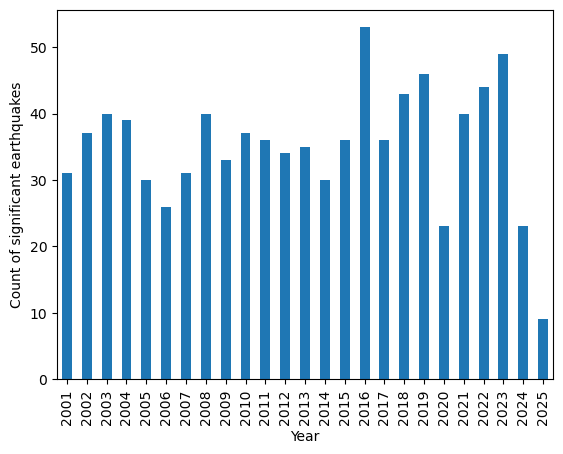

In [105]:
#task 5: own EDA
year_counts = eq_df['date_time'].dt.year.value_counts().sort_index()

plt.figure()
year_counts.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Count of significant earthquakes')

max_year  = year_counts.idxmax()
max_count = int(year_counts.max())

print(max_year, max_count)